# LikeWise

### A Comparison of Book Recommender Systems

### By _Owen Burton_ and _Tobias Reaper_

---
---

## Outline

* [Introduction]()
* [_Imports and Configuration_]()
* [Data]()
  * [Loading and Looking]()
  * [Wrangling and Exploration]()

---
---

## Introduction

### Stop! Collaborate and Filter

[Collaborative Filtering](https://d2l.ai/chapter_recommender-systems/recsys-intro.html#collaborative-filtering) (CF)

> In general, CF only uses the user-item interaction data to make predictions and recommendations.

---
---

## Imports and Configuration

In [2]:
# === General Imports === #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# === Configuration === #
%matplotlib inline
pd.options.display.max_columns = 100
pd.options.display.max_rows = 200

---
---

## Data

Intro to and explanation of dataset — why this dataset?

Here is the dataset used for the LikeWise recommender systems: [UCSD Book Graph - GoodReads Datasets](https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/home).

---

### Load and Look

Load the dataset and look at basic descriptive statistics.

* Shape
* Data types (and conversions, as needed)
* Null values
* Descriptive statistics
  * Pandas Profiling (?)
  * Distributions
  * Numerical range, mean, stdev
  * Categorical distributions, mode

#### Download data

To develop and validate the initial models, we'll be using a genre-wise subset of the full interactions dataset for the Mystery, Thriller & Crime genre. This subset contains ~24.8m interactions, as opposed to the ~229m of the full dataset.

Because there is no way to create the same subset of users and books, we cannot use the `book_id_map` or `user_id_map`.

In [9]:
# === Download goodreads_interactions_mystery_thriller_crime.json.gz === #
import gdown

file_id = "1xuujDT-vOMMkk2Kog0CTT9ADmnD8pa9D"
url = "https://drive.google.com/uc?id=" + file_id
gdown.download(url, output=None, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1zmylV7XW2dfQVCLeg1LbllfQtHD2KUon
To: /content/goodreads_interactions.csv
4.32GB [01:06, 65.3MB/s]


'goodreads_interactions.csv'

#### Load sample of interactions

In [4]:
# === First, load from gzipped json === #
import gzip
import json
from typing import List

def load_data(file_name: str, num_items: int) -> List[dict]:
  """Output a list of user-book interactions"""
  count = 0
  data = []
  with gzip.open(file_name) as fin:
      for l in fin:
          d = json.loads(l)
          count += 1
          data.append(d)
          
          if (num_items is not None) and (count == num_items):
              break
  return data

# === Load sample of 100,000 records === #
interactions = load_data(
    "/content/goodreads_interactions_mystery_thriller_crime.json.gz",
    num_items=100000
)

assert len(interactions) == 100000

In [5]:
# === Take a look at one of the records === #
interactions[-1]

{'book_id': '383028',
 'date_added': 'Fri Oct 03 08:02:16 -0700 2014',
 'date_updated': 'Fri Oct 03 08:02:21 -0700 2014',
 'is_read': False,
 'rating': 0,
 'read_at': '',
 'review_id': '146a9921627d10f82bd6ca12df6efbb2',
 'review_text_incomplete': '',
 'started_at': '',
 'user_id': '80881f5266512e9b860753b2d406d5dd'}

In [6]:
# === Insert into dataframe === #
inters = pd.DataFrame(interactions)
print(inters.shape)
inters.head()

(100000, 10)


,user_id,book_id,review_id,is_read,rating,review_text_incomplete,date_added,date_updated,read_at,started_at
0,8842281e1d1347389f2ab93d60773d4d,6392944,5e212a62bced17b4dbe41150e5bb9037,True,3,I haven't read a fun mystery book in a while a...,Mon Jul 24 02:48:17 -0700 2017,Sun Jul 30 09:28:03 -0700 2017,Tue Jul 25 00:00:00 -0700 2017,Mon Jul 24 00:00:00 -0700 2017
1,8842281e1d1347389f2ab93d60773d4d,2279538,556e9e3f00fb5b7e4eaa116764b771b0,False,0,,Wed Mar 29 00:27:14 -0700 2017,Wed Mar 29 00:27:14 -0700 2017,,
2,8842281e1d1347389f2ab93d60773d4d,20821043,4b15f8a08f04a17f9a47f2b76fec21e5,False,0,,Mon Mar 27 22:52:11 -0700 2017,Mon Mar 27 22:52:12 -0700 2017,,
3,8842281e1d1347389f2ab93d60773d4d,31184479,0b9fc382ad38c5804ec46df84d66be6e,False,0,,Fri Jan 06 16:22:46 -0800 2017,Fri Jan 06 16:22:46 -0800 2017,,
4,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,True,3,"A fun, fast paced science fiction thriller. I ...",Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017


---

### Wrangling and Exploration

* Dealing with null values
* Based on how the data will be used, what transformations should be done?

#### Data types and conversions

The timestamp columns did not get read in correctly. If they are to be used, they'll have to be converted.

However, I'm going to be ignoring the timestamp columns for now.

In [21]:
# === Clean unused columns === #
inters = inters[["user_id", "book_id", "rating"]].copy()
inters.head()

,user_id,book_id,rating
0,8842281e1d1347389f2ab93d60773d4d,6392944,3
1,8842281e1d1347389f2ab93d60773d4d,2279538,0
2,8842281e1d1347389f2ab93d60773d4d,20821043,0
3,8842281e1d1347389f2ab93d60773d4d,31184479,0
4,8842281e1d1347389f2ab93d60773d4d,28684704,3


In [22]:
# === Data types === #
inters.dtypes

user_id    object
book_id    object
rating      int64
dtype: object

#### Basic descriptive statistics

In [16]:
# Number of distinct users
unique_users = set(item["user_id"] for item in interactions)
len(unique_users)

1763

In [17]:
# Number of distinct books
unique_books = set(item["book_id"] for item in interactions)
len(unique_books)

33000

The interaction matrix is extremely sparse.

In [19]:
# === Look at sparsity === #

# Get df of 0-rated (not rated) books
inters_zero = inters[inters["rating"] == 0]
print(inters_zero.shape)
print(f"Number of 0 ratings: {inters_zero.shape[0]}")

# Get df of rated books
inters_rated = inters[inters["rating"] > 0]
print(inters_rated.shape)
print(f"Number of rated books: {inters_rated.shape[0]}")

# Calculate sparsity
sparsity = 1 - len(inters) / (len(unique_users) * len(unique_books))
print("Sparsity:", sparsity)

(50471, 10)
Number of 0 ratings: 50471
(49529, 10)
Number of rated books: 49529
Sparsity: 0.9982811667440141


The distribution of the ratings looks roughly normal, with a slight skew to the left.

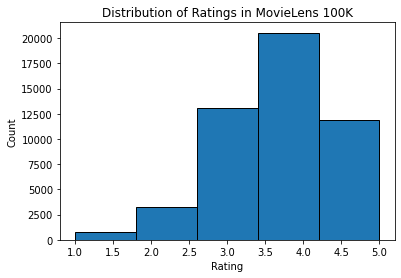

In [13]:
# === Distribution of ratings of rated books === #
# i.e. without the books with a rating of 0
plt.hist(inters_rated['rating'], bins=5, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in MovieLens 100K')
plt.show()